#Instalación

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 70.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DATA.xlsx to DATA.xlsx


#Datos Organización

In [ ]:
import pandas as pd

# Cargar datos desde la hoja 2
df = pd.read_excel("DATA.xlsx", sheet_name="Hoja2")

# Seleccionar y renombrar columnas relevantes
df_pydea = df[[
    "PUERTO",
    "INPUT1 (QL*WL)", "INPUT2 (INTERM*WI)", "INPUT3 (MLM*WK1)", "INPUT4 (SUP*WK2)",
    "SUMA CGC", "SUMA NCGC", "SUMA LB", "SUMA DB"
]].copy()

# Renombrar columnas para pyDEA
df_pydea.columns = [
    "DMU", "input1", "input2", "input3", "input4",
    "output1", "output2", "output3", "output4"
]

#Eficiencia Técnica

In [ ]:
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, LpStatus, value
import pandas as pd

efficiencies = []

for i, row in df_pydea.iterrows():
    model = LpProblem(f"DEA_BCC_Input_{row['DMU'].replace(' ', '_')}", LpMinimize)

    theta = LpVariable("theta", lowBound=0)
    lambdas = [LpVariable(f"lambda_{j}", lowBound=0) for j in range(len(df_pydea))]

    model += theta

    for k in ['input1', 'input2', 'input3', 'input4']:
        model += theta * row[k] >= lpSum(lambdas[j] * df_pydea.loc[j, k] for j in range(len(df_pydea)))

    for k in ['output1', 'output2', 'output3', 'output4']:
        model += lpSum(lambdas[j] * df_pydea.loc[j, k] for j in range(len(df_pydea))) >= row[k]

    model += lpSum(lambdas) == 1

    model.solve()

    efficiencies.append({
        "DMU": row["DMU"],
        "ET": round(value(theta), 6),
        "Es eficiente": round(value(theta), 6) == 1.0,
        "Estado": LpStatus[model.status],
    })

eff_df = pd.DataFrame(efficiencies).sort_values(by="DMU")
eff_df

,DMU,ET,Es eficiente,Estado
0,A CORUÑA,0.901378,False,Optimal
1,ALICANTE,0.709338,False,Optimal
2,AVILES,1.000000,True,Optimal
3,B. ALGEGIRAS,1.000000,True,Optimal
4,B. CADIZ,0.631544,False,Optimal
5,BALEARES,1.000000,True,Optimal
6,BARCELONA,1.000000,True,Optimal
7,BILBAO,0.561809,False,Optimal
8,CARTAGENA,1.000000,True,Optimal
9,CASTELLON,0.826150,False,Optimal


# Eficiencia Asignativa

In [ ]:
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, LpStatus, value

results = []
n = len(df_pydea)

for i, row in df_pydea.iterrows():
    # Coste observado
    C_obs = row[['input1','input2','input3','input4']].sum()

    # 1) CTE: coste técnico estimado (radial input-oriented BCC)
    m1 = LpProblem("CTE", LpMinimize)
    theta = LpVariable("theta", lowBound=0)
    lambdas1 = [LpVariable(f"l1_{j}", lowBound=0) for j in range(n)]
    m1 += theta * C_obs
    for k in ['input1','input2','input3','input4']:
        m1 += lpSum(lambdas1[j] * df_pydea.loc[j, k] for j in range(n)) <= theta * row[k]
    for k in ['output1','output2','output3','output4']:
        m1 += lpSum(lambdas1[j] * df_pydea.loc[j, k] for j in range(n)) >= row[k]
    m1 += lpSum(lambdas1) == 1
    m1.solve()
    theta_val = value(theta)
    CTE = theta_val * C_obs

    # 2) CSE: coste mínimo estimado
    m2 = LpProblem("CSE", LpMinimize)
    lambdas2 = [LpVariable(f"l2_{j}", lowBound=0) for j in range(n)]
    m2 += lpSum(lambdas2[j] * df_pydea.loc[j, ['input1','input2','input3','input4']].sum()
               for j in range(n))
    for k in ['input1','input2','input3','input4']:
        m2 += lpSum(lambdas2[j] * df_pydea.loc[j, k] for j in range(n)) <= row[k]
    for k in ['output1','output2','output3','output4']:
        m2 += lpSum(lambdas2[j] * df_pydea.loc[j, k] for j in range(n)) >= row[k]
    m2 += lpSum(lambdas2) == 1
    m2.solve()
    CSE = value(m2.objective)

    # 3) EA: eficiencia asignativa
    EA = CSE / CTE
    results.append({"DMU": row["DMU"], "EA": round(EA, 6)})

df_ea = pd.DataFrame(results)
df_ea

,DMU,EA
0,A CORUÑA,0.515536
1,ALICANTE,0.896507
2,AVILES,1.000000
3,B. ALGEGIRAS,1.000000
4,B. CADIZ,0.863117
5,BALEARES,1.000000
6,BARCELONA,1.000000
7,BILBAO,0.736134
8,CARTAGENA,1.000000
9,CASTELLON,0.904421


# Eficiencia Global

In [ ]:
# Unir ET y EA
df_eg = pd.merge(
    eff_df[["DMU", "ET"]],
    df_ea[["DMU", "EA"]],
    on="DMU"
)

# Calcular eficiencia global: EG = ET × EA
df_eg["EG"] = df_eg["ET"] * df_eg["EA"]

df_eg = df_eg.sort_values(by="DMU").reset_index(drop=True)
df_eg

,DMU,ET,EA,EG
0,A CORUÑA,0.901378,0.515536,0.464693
1,ALICANTE,0.709338,0.896507,0.635926
2,AVILES,1.000000,1.000000,1.000000
3,B. ALGEGIRAS,1.000000,1.000000,1.000000
4,B. CADIZ,0.631544,0.863117,0.545096
5,BALEARES,1.000000,1.000000,1.000000
6,BARCELONA,1.000000,1.000000,1.000000
7,BILBAO,0.561809,0.736134,0.413567
8,CARTAGENA,1.000000,1.000000,1.000000
9,CASTELLON,0.826150,0.904421,0.747187


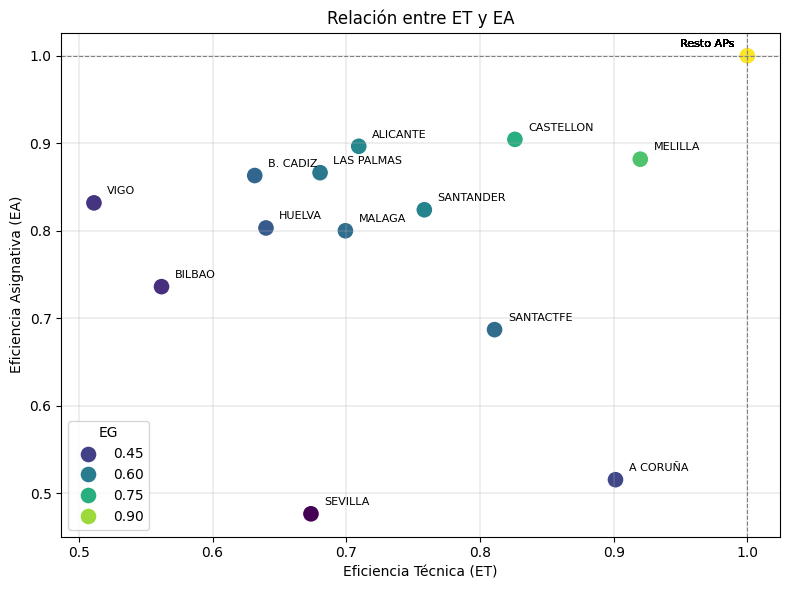

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Scatter plot
sns.scatterplot(data=df_eg, x="ET", y="EA", hue="EG", palette="viridis", s=150)

for i, row in df_eg.iterrows():
    if row["EG"] == 1.0:
        plt.text(row["ET"] - 0.01, row["EA"] + 0.01, "Resto APs", fontsize=8, color="black", ha="right")
    else:
        plt.text(row["ET"] + 0.01, row["EA"] + 0.01, row["DMU"], fontsize=8, color="black")

plt.axhline(1, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(1, color='gray', linestyle='--', linewidth=0.8)

plt.title("Relación entre ET y EA")
plt.xlabel("Eficiencia Técnica (ET)")
plt.ylabel("Eficiencia Asignativa (EA)")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()